In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from data_converter import DataConverter
from knm import knm_fit
from rich import print

In [2]:
# Wczytanie danych
data = pd.read_csv("primary_data.csv", sep=';')

{
    'Amanita Family': 8,
    'Lepiota Family': 3,
    'Tricholoma Family': 43,
    'Wax Gill Family': 8,
    'Russula Family': 27,
    'Pluteus Family': 2,
    'Entoloma Family': 7,
    'Bolbitius Family': 3,
    'Stropharia Family': 8,
    'Cortinarius Family': 11,
    'Mushroom Family': 5,
    'Ink Cap Family': 13,
    'Bolete Family': 14,
    'Paxillus Family': 3,
    'Chanterelle Family': 3,
    'Oyster Mushroom Family': 2,
    'Crepidotus Family': 1,
    'Hydnum Family': 1,
    'Ear-Pick Family': 1,
    'Bracket Fungi': 7,
    'Saddle-Cup Family': 1,
    'Morel Family': 1,
    'Jelly Discs Family': 1
}

<BarContainer object of 23 artists>

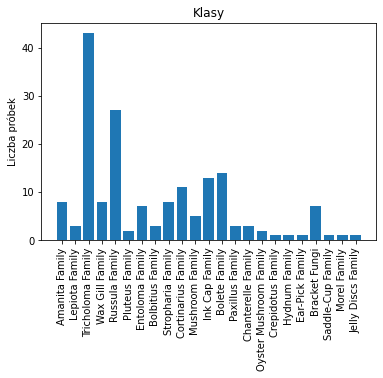

In [3]:
# zliczanie próbek w klasie
class_count = {}

for probe in data.values:
    class_name = probe[0]
    if class_name in class_count:
        class_count[class_name] += 1
    else:
        class_count[class_name] = 1
        
print(class_count)

plt.figure()
plt.title("Klasy")
plt.ylabel("Liczba próbek")
plt.xticks(rotation=90)

plt.bar(class_count.keys(), class_count.values())

In [4]:
# Jest 20 cech, cechy są w formie tekstowej i wymagają przetworzenia na liczby
# zbiór danych nie jest znormalizowany poniewaz posiada on litery co stanowi przeszkodę w drodzę do kwalifikacji, więc wymaga ono takiej czynności.

converter = DataConverter()
converted = converter.convert_data(data)
normalized = preprocessing.normalize(converted)

In [5]:
# Wyciągnięcie nazw klas i oddzielenie informacji o klasie do osobnego wektora

labels = data["family"].to_list()
classes = list(set(labels))

# Przypisanie numerów dla nazw klas
label_numbers = np.reshape(np.array([classes.index(label) for label in labels]), (len(labels), 1))

In [6]:
# Podział zbioru na testowego na testowy i walidacyjne

def split_data(data, train_percentage):
    return train_test_split(data, train_size=int(len(data)*train_percentage))

normalized_with_labels = np.append(normalized, label_numbers, 1)
train, test = split_data(normalized_with_labels, 0.8)

print(train.shape)
print(test.shape)


(138, 21)

(35, 21)

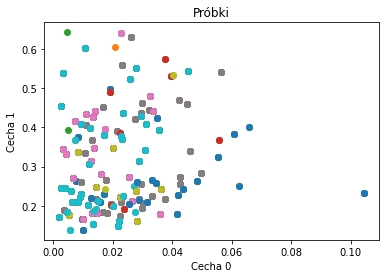

In [7]:
# Przykładowa wizualizacja dwóch cech

plt.figure()
plt.title("Próbki")
plt.xlabel("Cecha 0")
plt.ylabel("Cecha 1")

for class_nr in label_numbers:
    cls_data = train[train[:, -1] == class_nr]
    plt.scatter(cls_data[:, 0], cls_data[:, 1])

In [8]:
# Wybór najlepszych cech metodą "L1-based feature selection"
# Algorytm iteracyjny, pozwalający na znalezienie cech potencjalnie nadających
# się w największym stopniu do przeprowadzenia klasyfikacji 

lsvc = LinearSVC(dual=False, tol=1e-6).fit(train[:, :-1], train[:, -1].astype('int'))
model = SelectFromModel(lsvc, prefit=True)

train_new = model.transform(train[:, :-1])
test_new = model.transform(test[:, :-1])

# Wybrano najlepsze cechy
print(train_new.shape, train.shape)

(138, 9)
(138, 21)

In [9]:

from sklearn.metrics import confusion_matrix

# Klasyfikacja
# Konwersja numerów klas na typ 'int'

labels_int = train[:, -1].astype('int')

# NN
clf = KNeighborsClassifier(1)
clf.fit(train_new, labels_int)
predictions = clf.predict(test_new)

print("NN")
print(f"Accuracy: {round(100*sum(test[:, -1] == predictions)/len(predictions), 3)}%")
print(confusion_matrix(test[:, -1], predictions))

# k-NN
clf = KNeighborsClassifier(10)
clf.fit(train_new, labels_int)
predictions = clf.predict(test_new)

print("KNN")
print(f"Accuracy: {round(100*sum(test[:, -1] == predictions)/len(predictions), 3)}%")
print(confusion_matrix(test[:, -1], predictions))

# NM
print("NM")
predictions = knm_fit(train_new, labels_int, test_new, k=1)
print(f"Accuracy: {round(100*sum(test[:, -1] == predictions)/len(predictions), 3)}%")
print(confusion_matrix(test[:, -1], predictions))

# k-NM
print("k-NM")
predictions = knm_fit(train_new, labels_int, test_new, k=12)
print(f"Accuracy: {round(100*sum(test[:, -1] == predictions)/len(predictions), 3)}%")
print(confusion_matrix(test[:, -1], predictions))

# Przez to, że niektóre klasy posiadają po 1 próbce, wyniki KNM i NM są podobne

NN

Accuracy: 25.714%

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 1 0 0 2 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]

KNN

Accuracy: 31.429%

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 1 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]

NM

d:\studia\python\mushroom_classifier\.venv\lib\site-packages\scipy\spatial\distance.py:1069: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Accuracy: 2.857%

[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 0 0 3 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]

k-NM

d:\studia\python\mushroom_classifier\.venv\lib\site-packages\scipy\spatial\distance.py:1069: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Accuracy: 2.857%

[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 0 0 3 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]